## Standard Bank Hackathon

## Team: Occam's Razors

### Data Exploration

In [845]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

Load preprocessed data and separate columns

In [907]:
train_df = pd.read_csv('data/orders2Train_new.csv',index_col=0)
test_df = pd.read_csv('data/order2Test_new.csv',index_col=0)

full_df = pd.concat([train_df,test_df],axis=0)

weather_columns = [ 'cloud_cover',
                    'sunshine',
                    'global_radiation',
                    'max_temp',
                    'mean_temp',
                    'min_temp',
                    'precipitation',
                    'pressure',
                    'snow_depth']
date_columns = ['Year',
                'WeekOfYear',
                'weekOfMonth',
                'MonthOfYear']
holiday_columns = ['numHolidays']

cols = list(train_df.columns)
menu_start_idx = 13
menu_end_idx = -1
menu_columns = train_df.columns[menu_start_idx:menu_end_idx]

### Duplicate columns names

There are duplicate column names, with slight differences in punctuation and case.  Such columns are added together and the remaining duplicate column is removed.

In [795]:
menu_columns.map(str.lower).duplicated(keep='first').sum()

35

In [917]:
def add_and_remove_duplicates(df):
    l = lambda x: re.sub('-','',re.sub(' ','',str.lower(x)))

    lower_cols = df.columns.map(l)
    i=0
    while i < len(lower_cols):
        indices = np.where(df.columns.map(l)==lower_cols[i])[0]
        if len(indices)>1:
            first = indices[0]
            last = indices[1]
            df[df.columns[first]]=df[df.columns[first]]+df[df.columns[last]]
            #print('{}: {},\t\t{}: {}'.format(df.columns[first],df.iloc[:,first].sum(axis=0),df.columns[last],df.iloc[:,last].sum(axis=0)))
            df=df.drop([df.columns[last]],axis=1)
        i+=1
    return df

test_df=add_and_remove_duplicates(test_df)
train_df=add_and_remove_duplicates(train_df)

In [911]:
# test_df.to_csv('orders2Test_clean.csv')
# train_df.to_csv('orders2Train_clean.csv')

### Missing weekly data

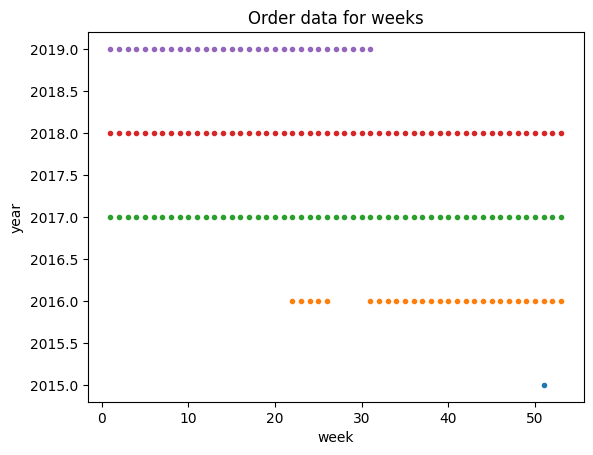

In [787]:
years = full_df['Year'].unique()

for y in years:
    weeks = full_df.query('Year=={}'.format(y))['WeekOfYear']
    plt.plot(weeks,y*np.ones(len(weeks)),'.')
plt.title('Order data for weeks')
plt.ylabel('year')
plt.xlabel('week')
plt.show()

### Heatmap plot of weekly product order

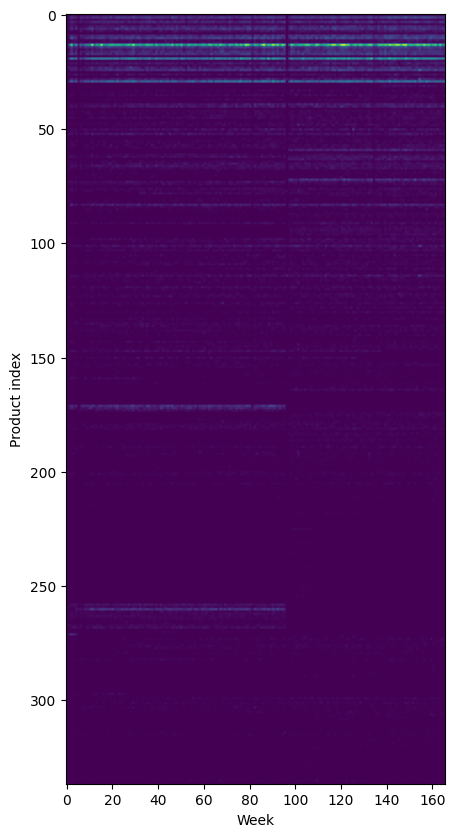

In [789]:
plt.figure(figsize=(19,10))
plt.ylabel('Product index')
plt.xlabel('Week')
plt.imshow(full_df[menu_columns].to_numpy().T)
plt.show()

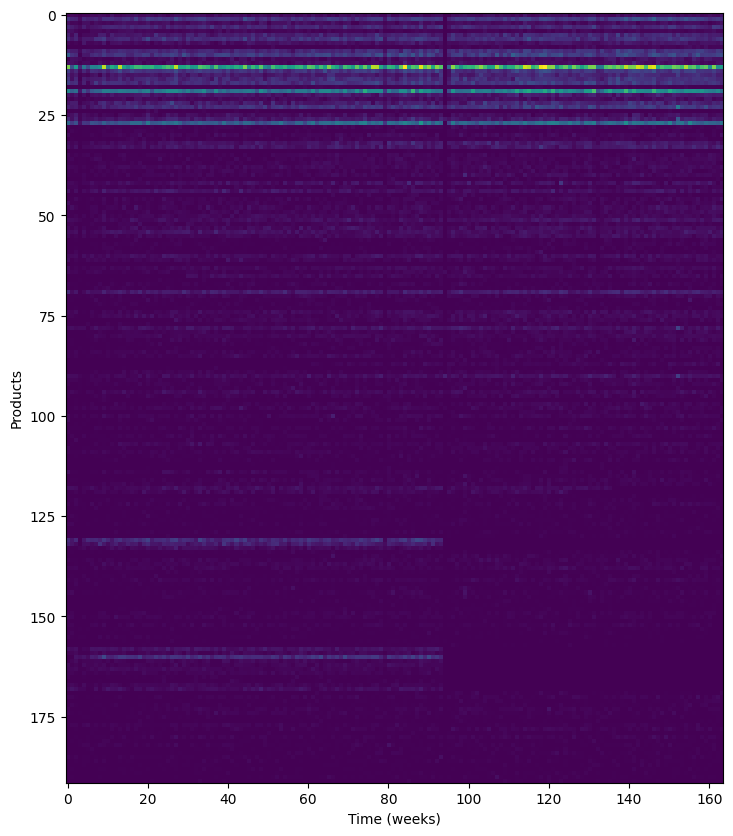

In [784]:
full_df = pd.concat([train_df,test_df],axis=0)

menu_df = full_df[menu_columns].reset_index(drop=True)

menu_left_df = menu_df.iloc[95:,:]#118
mask1 = ((menu_left_df>0).sum(axis=0)==0).values

menu_right_df = menu_df.iloc[:95,:]#113
mask2 = ((menu_right_df>0).sum(axis=0)==0).values

mask = [not (mask1[i] or mask2[i]) for i in range(len(mask1))]

keep_cols = list(menu_df.columns[mask])

heatmap = menu_df.iloc[2:,:][keep_cols].to_numpy().T

plt.figure(figsize=(19,10))
plt.ylabel('Products')
plt.xlabel('Time (weeks)')
plt.imshow(heatmap)
plt.show()


There was a clear distribution shift around the 32nd week of 2018.

In [790]:
#plt.imshow(full_df.iloc[90:140,150:200].T)

right = full_df.iloc[95:,:][menu_columns]#113
right_mask=(right.sum(axis=0)==0)
left = full_df.iloc[:95,:][menu_columns]#113
left_mask=(left.sum(axis=0)==0)

In [792]:
heatmap = full_df[menu_columns].to_numpy()
heatmap_im = heatmap*255/np.max(heatmap)

mask = np.ones_like(heatmap_im)==0
mask[95:,right_mask]=True
mask[:95,left_mask]=True

products_of_interest = menu_columns[np.sum(mask.T==True,axis=1)==0]
df = pd.DataFrame(products_of_interest)
df.to_csv('focus_products.csv')

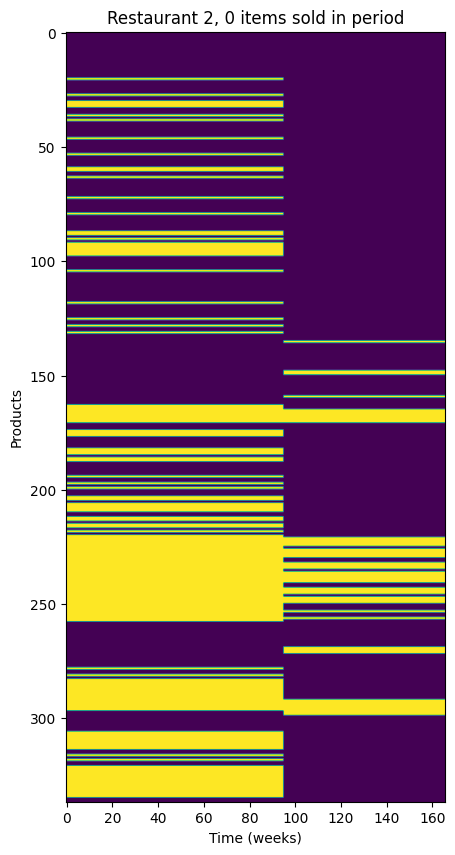

In [794]:
plt.figure(figsize=(19,10))
plt.ylabel('Products')
plt.xlabel('Time (weeks)')
plt.title('Restaurant 2, 0 items sold in period')
plt.imshow(mask.T)
plt.show()

In [125]:
cols = list(full_df.columns)
menu_start_idx = 13#cols.index('Aloo Chaat')
menu_end_idx = 261#cols.index('Kurma')
menu_columns = full_df.columns[menu_start_idx:(menu_end_idx+1)]
menu_df = full_df[menu_columns]


### Log rule in order frequency

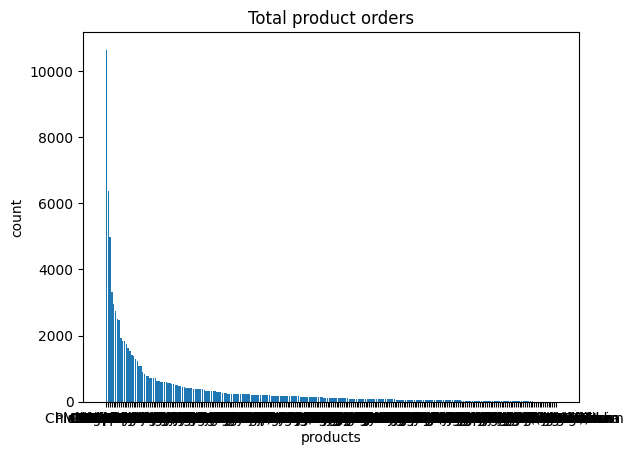

In [110]:
product_freq_df = (menu_df.sum(axis=0)).sort_values(ascending=False)
plt.bar(product_freq_df.index,product_freq_df.values)
plt.title('Total product orders')
plt.xlabel('products')
plt.ylabel('count')
plt.show()